In [2]:
import cv2
import glob
import tqdm
import torch
import random
import pickle
import pytesseract
import matplotlib.pyplot as plt
from peft import LoraConfig, PeftModel, TaskType
from transformers import AutoModelForSequenceClassification, AutoTokenizer

In [3]:
random.seed(42)

In [5]:
# Windows
#pytesseract.pytesseract.tesseract_cmd = r"C:/Program Files/Tesseract-OCR/tesseract.exe"
# Mac
pytesseract.pytesseract.tesseract_cmd = r"/usr/local/Cellar/tesseract/5.3.4_1/bin/tesseract"

In [15]:
idMap = {'Miscellaneous Category - Miscellaneous Bills': 3,
         'Travel Category - Flight Ticket': 7,
         'Electronics Category - Electronic Gadgets Bill/Receipt': 0,
         'Travel Category - Train Ticket': 8,
         'Travel Category - Cab Bill/Receipt': 6,
         'Room Stay Category - Stay Bill/Receipt': 4,
         'Travel Category - Bus Ticket': 5,
         'Food Category - Restaurant Bill/Receipt': 1,
         'Fuel Category - Fuel Bill/Receipt': 2}

In [16]:
labelMap = {3: 'Miscellaneous Category - Miscellaneous Bills',
            7: 'Travel Category - Flight Ticket',
            0: 'Electronics Category - Electronic Gadgets Bill/Receipt',
            8: 'Travel Category - Train Ticket',
            6: 'Travel Category - Cab Bill/Receipt',
            4: 'Room Stay Category - Stay Bill/Receipt',
            5: 'Travel Category - Bus Ticket',
            1: 'Food Category - Restaurant Bill/Receipt',
            2: 'Fuel Category - Fuel Bill/Receipt'}

In [17]:
imgFiles = [glob.glob("../sampleData/"+y) for y in ['*.jpg', '*.png', '*.tiff', '*.bmp', '*.jpeg']]
imgFiles = sum(imgFiles , [])
imgFiles

['../sampleData/trainTickets_22.png',
 '../sampleData/restaurantBills_17.png',
 '../sampleData/trainTickets_20.png',
 '../sampleData/trainTickets_21.png',
 '../sampleData/busTickets_4.png',
 '../sampleData/fuelBills_141.png',
 '../sampleData/stayReceipts_12.png',
 '../sampleData/stayReceipts_13.png',
 '../sampleData/fuelBills_140.png',
 '../sampleData/busTickets_2.png',
 '../sampleData/gadgetsBills_9.png',
 '../sampleData/fuelBills_142.png',
 '../sampleData/stayReceipts_11.png',
 '../sampleData/busTickets_3.png',
 '../sampleData/cabBills_49.png',
 '../sampleData/flightTickets_10.png',
 '../sampleData/cabBills_50.png',
 '../sampleData/cabBills_51.png',
 '../sampleData/flightTickets_11.png',
 '../sampleData/gadgetsBills_10.png',
 '../sampleData/restaurantBills_18.png',
 '../sampleData/restaurantBills_19.png',
 '../sampleData/gadgetsBills_15.png',
 '../sampleData/flightTickets_9.png']

In [18]:
imgName = imgFiles[7]
imgName

'../sampleData/stayReceipts_13.png'

In [19]:
img = cv2.imread(imgName, 0)
img

libpng warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)

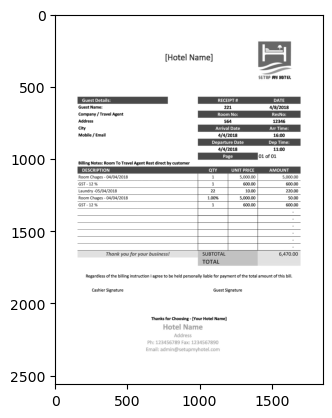

In [20]:
plt.imshow(img, cmap = "gray")

In [21]:
txtOut = pytesseract.image_to_string(img)
txtOut

'[Hotel Name]\n\nSETUP MY HOTEL\n\nGuest Name: siBienns\nAddress ee\n\ncy\nMobile / Email 4/4/2018 16:00\n\nDeparture Date Dep Time:\n\n4/4/2018 11:00\n\nTT 01 of 01\n\nBilling Notes: Room To Travel Agent Rest direct by customer\n\nDESCRIPTION UNIT PRICE AMOUNT\nRoom Chages - 04/04/2018 5,000.00 5,000.00\nGST-12% 600.00 600.00\nLaundry -05/04/2018 10.00 220.00\nRoom Chages - 04/04/2018 5,000.00 50.00\nGST-12% 600.00 600.00\n\nThank you for your business! SUBTOTAL 6,470.00\n\nTOTAL\nRegardless of the billing instruction | agree to be held personally liable for payment of the total amount of this bill.\n\nCashier Signature Guest Signature\n\nThanks for Choosing - [Your Hotel Name]\n\nHotel Name\nAddress\nPh: 123456789 (: 1234567890\nEmail: admin@setupmyhotel.com\n\n'

In [25]:
model = AutoModelForSequenceClassification.from_pretrained("google/mobilebert-uncased", num_labels=len(labelMap), id2label=idMap, label2id=labelMap)
tokenizer = AutoTokenizer.from_pretrained("google/mobilebert-uncased")

Some weights of MobileBertForSequenceClassification were not initialized from the model checkpoint at google/mobilebert-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [26]:
model = PeftModel.from_pretrained(model, 'trainedMobileBERTLoRA')

In [28]:
loraModel = model.merge_and_unload()

In [29]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
loraModel.to(device)

MobileBertForSequenceClassification(
  (mobilebert): MobileBertModel(
    (embeddings): MobileBertEmbeddings(
      (word_embeddings): Embedding(30522, 128, padding_idx=0)
      (position_embeddings): Embedding(512, 512)
      (token_type_embeddings): Embedding(2, 512)
      (embedding_transformation): Linear(in_features=384, out_features=512, bias=True)
      (LayerNorm): NoNorm()
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): MobileBertEncoder(
      (layer): ModuleList(
        (0-23): 24 x MobileBertLayer(
          (attention): MobileBertAttention(
            (self): MobileBertSelfAttention(
              (query): Linear(in_features=128, out_features=128, bias=True)
              (key): Linear(in_features=128, out_features=128, bias=True)
              (value): Linear(in_features=512, out_features=128, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): MobileBertSelfOutput(
              (dense): Linear(in_fe

In [30]:
txtOut

'[Hotel Name]\n\nSETUP MY HOTEL\n\nGuest Name: siBienns\nAddress ee\n\ncy\nMobile / Email 4/4/2018 16:00\n\nDeparture Date Dep Time:\n\n4/4/2018 11:00\n\nTT 01 of 01\n\nBilling Notes: Room To Travel Agent Rest direct by customer\n\nDESCRIPTION UNIT PRICE AMOUNT\nRoom Chages - 04/04/2018 5,000.00 5,000.00\nGST-12% 600.00 600.00\nLaundry -05/04/2018 10.00 220.00\nRoom Chages - 04/04/2018 5,000.00 50.00\nGST-12% 600.00 600.00\n\nThank you for your business! SUBTOTAL 6,470.00\n\nTOTAL\nRegardless of the billing instruction | agree to be held personally liable for payment of the total amount of this bill.\n\nCashier Signature Guest Signature\n\nThanks for Choosing - [Your Hotel Name]\n\nHotel Name\nAddress\nPh: 123456789 (: 1234567890\nEmail: admin@setupmyhotel.com\n\n'

In [31]:
encodedData = tokenizer(txtOut, padding="max_length", truncation=True, max_length=512)

In [32]:
input_ids = torch.tensor([encodedData["input_ids"]], dtype=torch.uint8).to(device).long()
attention_mask = torch.tensor([encodedData["attention_mask"]], dtype=torch.uint8).to(device)

In [33]:
with torch.no_grad():
  outputs = loraModel(input_ids=input_ids, attention_mask=attention_mask)
  logits = outputs.logits
  predOut = torch.argmax(logits, dim=1)

In [34]:
logits

tensor([[  3.5550,   5.6929,  -1.9624, -29.2365,   7.0729,  -4.9064,   0.5171,
          -3.0139,  -6.3338]])

In [35]:
confVals = torch.nn.functional.softmax(logits, dim=1)
confVals

tensor([[2.3123e-02, 1.9611e-01, 9.2861e-05, 1.3269e-16, 7.7953e-01, 4.8899e-06,
         1.1084e-03, 3.2449e-05, 1.1732e-06]])

In [36]:
labelMap[predOut.item()]

'Room Stay Category - Stay Bill/Receipt'

In [37]:
confVals[0, predOut.item()]

tensor(0.7795)

# Traversing through all the Bill Yo !

In [38]:
model = AutoModelForSequenceClassification.from_pretrained("google/mobilebert-uncased", num_labels=len(labelMap), id2label=idMap, label2id=labelMap)
tokenizer = AutoTokenizer.from_pretrained("google/mobilebert-uncased")

Some weights of MobileBertForSequenceClassification were not initialized from the model checkpoint at google/mobilebert-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [39]:
model = PeftModel.from_pretrained(model, 'trainedMobileBERTLoRA')

In [40]:
loraModel = model.merge_and_unload()

In [41]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
loraModel.to(device)

MobileBertForSequenceClassification(
  (mobilebert): MobileBertModel(
    (embeddings): MobileBertEmbeddings(
      (word_embeddings): Embedding(30522, 128, padding_idx=0)
      (position_embeddings): Embedding(512, 512)
      (token_type_embeddings): Embedding(2, 512)
      (embedding_transformation): Linear(in_features=384, out_features=512, bias=True)
      (LayerNorm): NoNorm()
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): MobileBertEncoder(
      (layer): ModuleList(
        (0-23): 24 x MobileBertLayer(
          (attention): MobileBertAttention(
            (self): MobileBertSelfAttention(
              (query): Linear(in_features=128, out_features=128, bias=True)
              (key): Linear(in_features=128, out_features=128, bias=True)
              (value): Linear(in_features=512, out_features=128, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): MobileBertSelfOutput(
              (dense): Linear(in_fe

  0%|          | 0/24 [00:00<?, ?it/s]

../sampleData/trainTickets_22.png


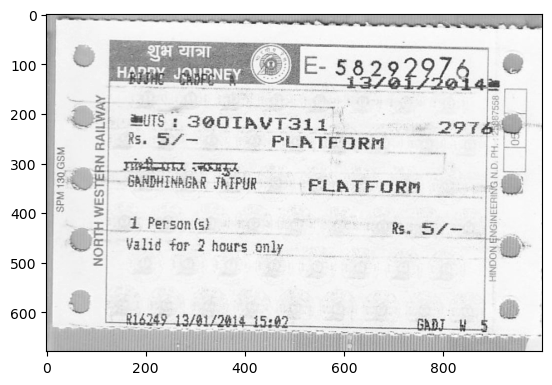

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Ja at

HAD JOCSNE hs

ayts 3 | S@0TAVT311 | mw 2o7ep

6. SY 0 PLATFORM ees
=
g _Tidiar sag 2
8 ~ GANDHINAGAR JAIPUR PLATFORM jo
= =

Valid for 2 hours only _

g
=

_4i Person(s} &. S/—. ae




  4%|▍         | 1/24 [00:03<01:12,  3.13s/it]

outStuff:  Travel Category - Train Ticket
Confidence Yo:  tensor(0.7326)








../sampleData/restaurantBills_17.png


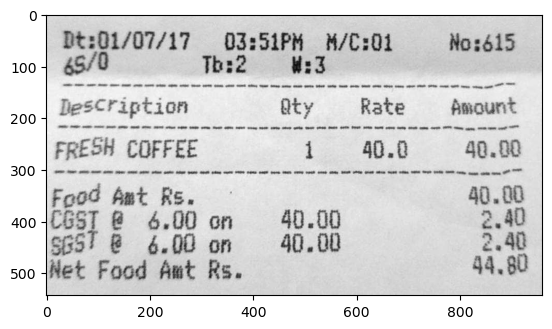

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Dt:01/07/17 03:51PM M/C:01 No:615
65/0 Th:2 :

Ws
Description Qty Rate  fmount
FRESH COFFEE i 40.0 40.00
Food Aut Rs. 40.00
C65T @ 6.00 on 40.00 2.40
s651 @ 4.00 on 40.00 2.40

Net Food Amt Rs. 44,80



  8%|▊         | 2/24 [00:05<00:55,  2.52s/it]

outStuff:  Food Category - Restaurant Bill/Receipt
Confidence Yo:  tensor(0.9986)








../sampleData/trainTickets_20.png


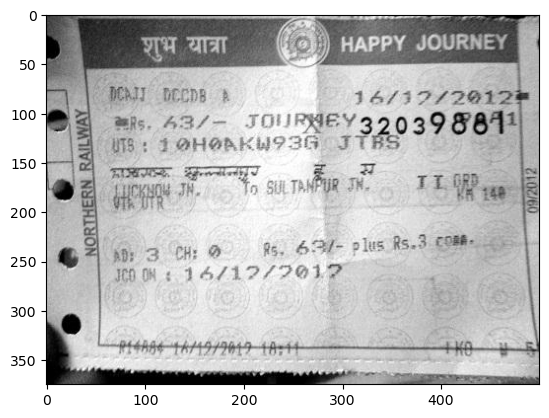

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


16/37/2012

Ti Fie rid TL Op.
jg “4 on Tae




 12%|█▎        | 3/24 [00:06<00:43,  2.08s/it]

outStuff:  Food Category - Restaurant Bill/Receipt
Confidence Yo:  tensor(0.6638)








../sampleData/trainTickets_21.png


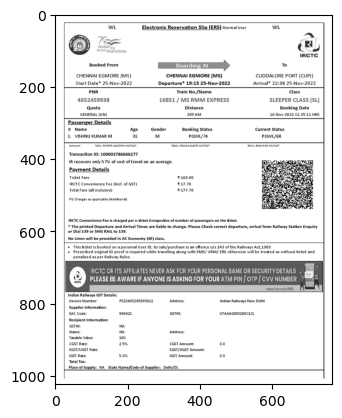

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


wi Reservation Slip (ERS)-Normal User we
5 -— re]
Azaditg
Athos Go”)
IRCTC
Booked From Board To
‘CHENNAI EGMORE (MS) CHENNAI EGMORE (Ms) CUDDALORE PORT (CUPS)
Start Date* 25-Nov-2022 Departure* 19:15 25-Nov-2022 Arrival* 22:38 25-Nov-2022
PNR Train No/Name Class
4652459938 16851 / MS RMM EXPRESS SLEEPER CLASS (SL)
Quota Distance Booking Date
GENERAL (GN) 205 KM. 16-Nov-2022 11:25:11 HRS
Passenger Details
# Name Age Gender Booking status Current status
1. VISHNU KUMAR M 3h M Pawl/74 Pawves

‘Transaction ID: 100003786666277
IR recovers only 57% of cost of travel on an average.

Payment Detail
Ticket Fare 160.00
IRCTC Convenience Fee (inc. of GST) 17.70

Total Fare (all inclusive) "177.70

Charges 2s applicable (Addiiona)

IRCTC Convenience Fee is charged per e-ticket irrespective of number of passengers on the ticket.
"The printed Departure and Arrival Times are liable to change. Please Check correct departure, arrival from Railway Station Enquiry
(or Dial 139 or SMS RAIL to 139.

No Lin

 17%|█▋        | 4/24 [00:10<00:50,  2.55s/it]

outStuff:  Travel Category - Train Ticket
Confidence Yo:  tensor(0.9993)








../sampleData/busTickets_4.png


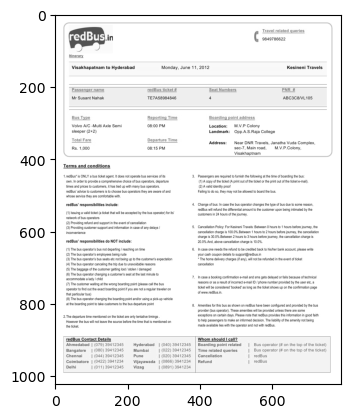

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


redBusky
2

inerary

isakhapatnam to Hyderabad

Monday, June 11, 2012

Travel related queries
4 9849786622

Kesineni Travels

Passengername redBus ticket #

Seat Numbers PNR

Mr Susant Nahak TE7ASBOB4846

4 ABC3CBIVL105

Bus Type Reporting Time
Volvo AIC -Multi Axle Semi 08:00 PM
sleeper (2+2)

Total Fare Departure Time
Rs. 1,000 08:15 PM

‘Terms and conditions

{.rous"is ONLY a bus ket agent It does not pera bus senes ots
‘un. n créer to provide a comprehensive chico of bus operators, depare
{irae and past customers, has dup with many bus operas
‘edBus' ice to customers stn chose bus cpeaos they are anare of ard
hose serice hey are confab wit,

‘redBus' responsibilities include:

(1) suing vali cat (atcha tat ibe accaple bythe bus operator rite
etn of bus operators

(2) roving refund and supa in the evento canolaton

{@) Proving customer support and informatn in case of any clays

‘edBus' responsibilities do NOT include:

(1) The bus operat bs ot departing tectngon ine
(2) The bus ope

 21%|██        | 5/24 [00:14<01:04,  3.40s/it]

outStuff:  Travel Category - Bus Ticket
Confidence Yo:  tensor(0.9790)








../sampleData/fuelBills_141.png


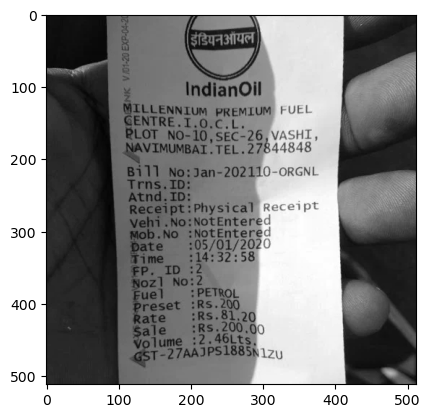

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


VASHI,

10-ORGNL

eceipt




 25%|██▌       | 6/24 [00:17<00:53,  2.98s/it]

outStuff:  Food Category - Restaurant Bill/Receipt
Confidence Yo:  tensor(0.5200)








../sampleData/stayReceipts_12.png


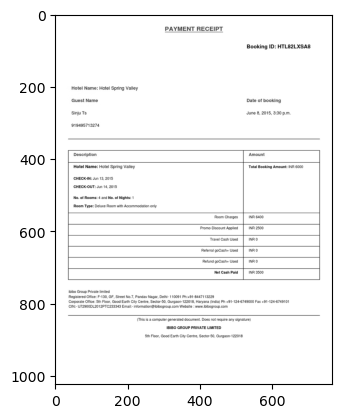

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Hotel Name: Hotel Spring Valley

PAYMENT RECEIPT

Booking ID: HTL82LXSA8

Guest Name Date of booking
Sinju Ts June 8, 2015, 3:30 p.m.
919498713274

Description ‘Amount

Hotel Name: Hotel Spring Valley

CHECKAN: Jun 13, 2015,
‘CHECK-OUT: Jun 14,2015,

No.of Rooms: 4 snd No.of Nights:

Room Type: Deluxe Room with Accommodation only

‘Total Booking Amount: INR 6000

Room Charges | INA 6400

Promo-DacountAppied | INR 2300
Travel Gash Used | RO
Reteralgocash« Uses | NRO
Retund goCashs Used | INRO

Netash Paid | INA 9500

Ibibo Group Privat ited

Registered Otce:F-180, GF, Sueet No.7, Pandav Nagar, Deh- 110081 Ph:+81-8447118228
Corporate Otice: Sth Floor, Good Earth Gly Centre, Sector-50, Gurgaon-122018, Haryana (Inia) Ph +91-124:6749000 Fax +91-126-6749101
{GIN U72900012012°TC28384S Emal- information bibogroup com Website : www. biboproup.com

(This isa computer generated document, Does not requie any signature)

IBIBO GROUP PRIVATE LIMITED

‘5th Floor, Good Earth Cy Centre, Sectr-50, Gurga

 29%|██▉       | 7/24 [00:19<00:48,  2.83s/it]

outStuff:  Room Stay Category - Stay Bill/Receipt
Confidence Yo:  tensor(0.7454)








../sampleData/stayReceipts_13.png


libpng warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


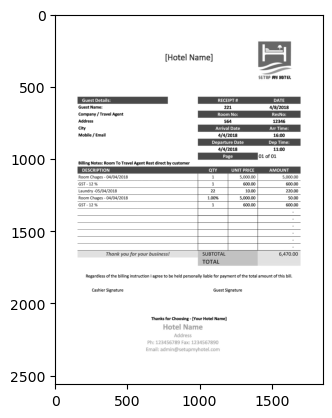

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


[Hotel Name]

SETUP MY HOTEL

Guest Name: siBienns
Address ee

cy
Mobile / Email 4/4/2018 16:00

Departure Date Dep Time:

4/4/2018 11:00

TT 01 of 01

Billing Notes: Room To Travel Agent Rest direct by customer

DESCRIPTION UNIT PRICE AMOUNT
Room Chages - 04/04/2018 5,000.00 5,000.00
GST-12% 600.00 600.00
Laundry -05/04/2018 10.00 220.00
Room Chages - 04/04/2018 5,000.00 50.00
GST-12% 600.00 600.00

Thank you for your business! SUBTOTAL 6,470.00

TOTAL
Regardless of the billing instruction | agree to be held personally liable for payment of the total amount of this bill.

Cashier Signature Guest Signature

Thanks for Choosing - [Your Hotel Name]

Hotel Name
Address
Ph: 123456789 (: 1234567890
Email: admin@setupmyhotel.com




 33%|███▎      | 8/24 [00:24<00:55,  3.49s/it]

outStuff:  Room Stay Category - Stay Bill/Receipt
Confidence Yo:  tensor(0.7795)








../sampleData/fuelBills_140.png


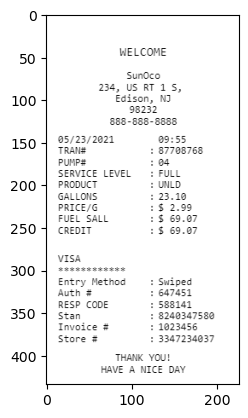

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


WELCOME

Sundco
234, US RT 1S,
Edison, NI
98232

888-888-8888
05/23/2021 29:55
TRANS +: 87708768
PUNE 24
SERVICE LEVEL: FULL
PRODUCT UNLD
GALLONS 23.18
PRICE/G $ 2.99
FUEL SALL $ 69.07
CREDIT $ 69.07
VISA
Entry Method: Suiped
Auth # 647451
RESP CODE 588141
Stan 5240347580
Invoice 11023456
Store # 3347234037

THANK YOU!

HAVE A NICE DAY



 38%|███▊      | 9/24 [00:26<00:43,  2.91s/it]

outStuff:  Travel Category - Bus Ticket
Confidence Yo:  tensor(0.2282)








../sampleData/busTickets_2.png


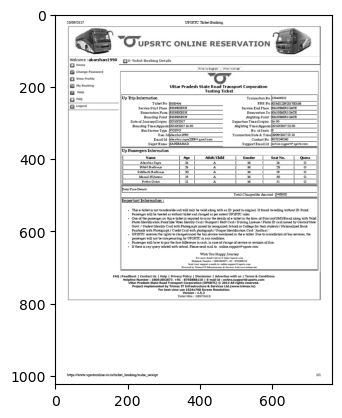

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


09017

LUPSRIC Ticket Booking,

1 crange Password
1 view Prone

My Booking
aM

ane

Topout

~~ .
© ‘Gorsrtc ONLINE RESERVATION y

‘Welcome :akarshani990_ (3 £-Ticket Booking Details

Uttar Pradesh State Road Transport Corporation

Testing Ticket
[Up Tip Information Franaction Vo PA?
Tiel o ss5086 PNR No SRGEOSOTROESS
Servee Start Place: REEDS, ‘Service Ena Place: KASERORIGATE
Reservation Fon SHEESH Reservation To, KASIOEREGATE.
Boarding Point SEEKS _Abgting Post: FASEDGRI GATE
Date of Journey Origin) POOR Departure Tune(Origay 630)
‘Bouding Tim e( Approx BOO017 1630 Alighting Tne Apps NOIT=SIO
‘BusServee Type WOEVO Yo ofSeats:B.
‘Use Linn ‘Teansaction Date & Time SOAR
Ewald: Waste peSiOve pea Contact No: PeESeI0_
| Depot Name FABIBARAD. Soypost Email ld: belnereppen@upreco=
Up Passengers Information
L ‘Name i ‘Gender [SeatNe. [Quota
i “Riawhns Sap L

foe
mal
ca

+ Thise-setetis not tmnsfenble and wil nly be valid along with an prot i ougial own raveling wthoet ID roo,
‘Passenger willbe

 42%|████▏     | 10/24 [00:29<00:41,  2.94s/it]

outStuff:  Travel Category - Bus Ticket
Confidence Yo:  tensor(0.8192)








../sampleData/gadgetsBills_9.png


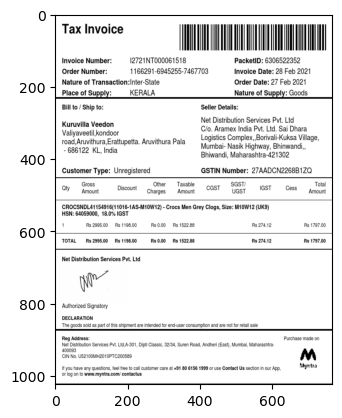

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


mess

Invoice Number: 12721NT000061518 PacketID: 6306522352
Order Number: 1166291-6945255-7467703 Invoice Date: 28 Feb 2021
Nature of Transaction:Inter-State Order Date: 27 Feb 2021
Place of Supply: KERALA Nature of Supply: Goods
Bill to / Ship to: Seller Details:

Net Distribution Services Pvt. Ltd

C/o. Aramex India Pvt. Ltd. Sai Dhara
Logistics Complex,,Borivali-Kuksa Village,
Mumbai- Nasik Highway, Bhinwandi,,
Bhiwandi, Maharashtra-421302

Kuruvilla Veedon

Valiyaveetil,kondoor
road,Aruvithura,Erattupetta. Aruvithura Pala
- 686122 KL, India

Customer Type: Unregistered GSTIN Number: 27AADCN2268B1ZQ.
Gross Other Taxable sGsT/ Total

Qty Amount Discount Charges Amount CST ygst «GST CSS Amount

CROCSNDL41154916(11016-1AS-M10W/12) - Crocs Men Grey Clogs, Size: M10W12 (UK)

HSN: 64059000, 18.0% IGST

1 Rs 2995.00 Rs 1198.00 Rs0.00 Rs 1522.68 Rs 274.12 Rs 1797.00

TOTAL Rs 2995.00 Rs 1198.00 Rs 0.00 Rs 1522.88 Rs 274.12 Rs 1797.00

Net Distribution Services Pvt. Ltd

Authorized Signatory

 46%|████▌     | 11/24 [00:31<00:36,  2.78s/it]

outStuff:  Electronics Category - Electronic Gadgets Bill/Receipt
Confidence Yo:  tensor(0.9920)








../sampleData/fuelBills_142.png


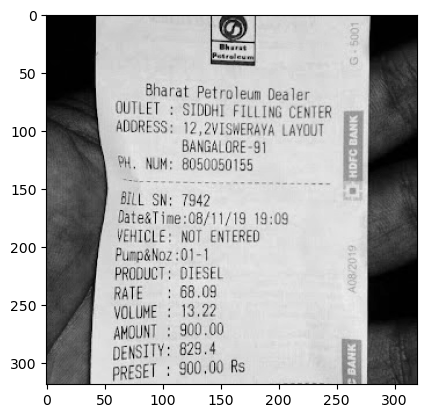

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


ie

Bharat Petroleum Dea
TDOHI FILLING CE

BILL SN: 7942
DateaT ine=08/11/19 19:09

VEHICLE: NOT ENTERED
PumpaNoz :01

PRODUC’

RATE

VOLUME : 13. 2
AMOUNT. = 800,00

829.4
900,00 Rs




 50%|█████     | 12/24 [00:33<00:30,  2.54s/it]

outStuff:  Fuel Category - Fuel Bill/Receipt
Confidence Yo:  tensor(0.9983)








../sampleData/stayReceipts_11.png


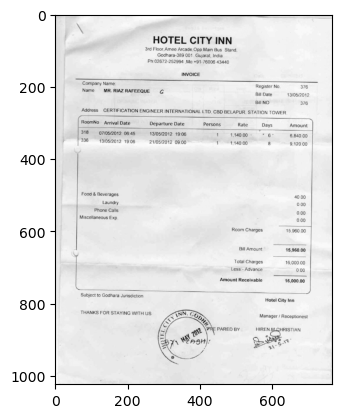

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


HOTEL CITY INN

31d Floor Ame Arcade,Opp Main Bus Stand,
Godhara-389 001. Gujarat, India
Ph:02672-252994 Mo'+91-76006 43440

INVOICE

Company Name Register No. 376
Name  MR.RIAZRAFEEQUE BillDate 19/08/2012

Bill NO 376
Address CERTIFICATION ENGINEER INTERNATIONAL LTD. CBD BELAPUR, STATION TOWER

RoomNo Arrival Date Departure Date Persons Rate Days Amount
318 0770572012 06:45 13/05/2012 19:06 1 114000" * 6° 6840.00
936 "19/05/2012 1906 21/05/2012 09.00 1 4.14000 8 9,120.00
Food & Beverages 40.00
Laundry 000
Phone Calls 0.00
Miscellaneous Exp 0.00
Room Charges 1,960.00
Bil Amount 15,960.00
Total Charges 16,000.00
Less - Advance 0.00
Amount Receivable 16,000.00

‘Subject to Godhara Jurisdiction Hotel City Inn

THANKS FOR STAYING WITH US Manager / Receptionest

PARED BY HIREN.M.QHRISTIAN

en
w?




 54%|█████▍    | 13/24 [00:37<00:32,  2.98s/it]

outStuff:  Room Stay Category - Stay Bill/Receipt
Confidence Yo:  tensor(0.9337)








../sampleData/busTickets_3.png


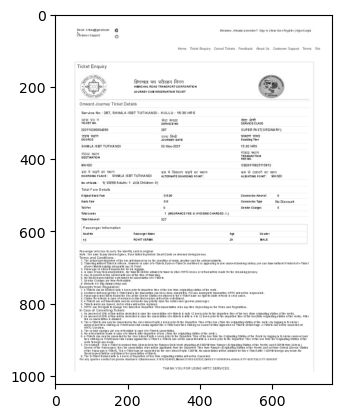

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


enema @ eto Ama amenbr Syn te rages ates
Siemon

Home Tiket Enquiry Cancel Ticats Feedback Abot Us Customer Support Tems Shi

Ticket Enquiry

> ‘fare ver atiaea Pere

oe
‘Onward Journey Ticket Details

‘Service No = 287, SHIMLA ISBT TUTIKANDI- KULLU : 15:30 HRS.

ero" So Rive
ocwesnouso a SuPeR rsTIORONARY)
sem ara i ——
mar Sates ae
SHIMLA IST TUTKANOL onevan 1500 HRS
re ie
saa wet a eo S04 ee woh 7 wr a8 owe an
Tinouo vce SHEA BETTUTHANOL — MetaneTonnion Mouse Momo rowr uavor
vero REARS: ae Cee: 0}
Teal Fare Data
ry Site inant
= cominnton —_ WeOsceut
oumcnm 6
; Somer RSSECoRTSTS
Ea
assengeInfrmaton
oo asp '* aia
‘s rownvenun 5 we

gy no ha cary be wnt earain or
SSW tna ane Dpayobeottghefyou ike poate Smarcant orm

sFubethou Sight cain Sie wie

"Efotitpns bor anprure one othe bu gam arghang Ha

cpa mrcmmame sai orae pee) oy momen Bux
GGpeamson Tineh oransage ered caster .

Pore) ame

cna te ast

yestaaby ae ett a eae ae

ise p 0 Nocatee

Fate tonin  aiateap mes

caSneses aura 96160505 

 58%|█████▊    | 14/24 [00:44<00:40,  4.03s/it]

outStuff:  Travel Category - Bus Ticket
Confidence Yo:  tensor(0.6022)








../sampleData/cabBills_49.png


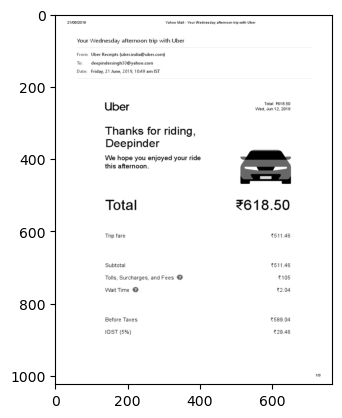

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


2vo8r2010 ‘Yahoo Mail- Your Wednesday afternoon tip with Uber

Your Wednesday afternoon trip with Uber

From: Uber Receipts (ub

\dia@ uber.com)

To: — deepindersingh30@yahoo.com

Friday, 21 June, 2019, 10:49 am IST

ame
Uber Wed jan 12,2018

Thanks for riding,
Deepinder

We hope you enjoyed your ride
this afternoon.

Total 2618.50

Trip fare 3511.46
‘Subtotal 511.46
Tolls, Surcharges, andFees @ 105
Wait Time @ 2.04
Before Taxes 589.04

IGST (5%) §29.48

12



 62%|██████▎   | 15/24 [00:46<00:32,  3.60s/it]

outStuff:  Travel Category - Cab Bill/Receipt
Confidence Yo:  tensor(0.9372)








../sampleData/flightTickets_10.png


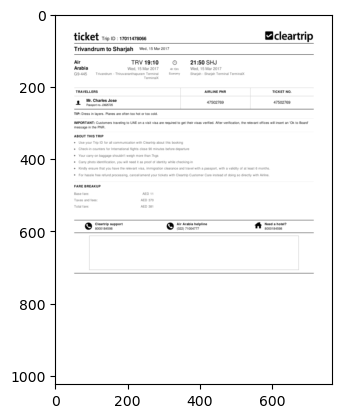

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


ticket rico: rzo1ra7e066 Qcleartrip

Trivandrum to Sharjah Wed, 15 Mar2017

Air TRV 19:10 fo} 21:50 SHJ

Arabia Wed, 15Mar 2017 Wed, 15 Mar 201

‘TRAVELLERS AIRLINE PNR TICKET NO.
Mr. Charles Jose
2 ries Jot 47502769 47502769

TIP: Dress in layers. Panes ae ten 100 hot 100 cold

IMPORTANT: Customers waving to UAE ona vit isa ae requived to get tha visas verted Alter veiicaio, the elovantotices wi lnsen an‘ to Boar
message n the PNA,

ABOUT THIS TRIP.

FARE BREAKUP
Cleartrip support ‘Ar Arabia hep Need a hotel?

eooot84so8 (c22) 71008777




 67%|██████▋   | 16/24 [00:50<00:28,  3.56s/it]

outStuff:  Room Stay Category - Stay Bill/Receipt
Confidence Yo:  tensor(0.3315)








../sampleData/cabBills_50.png


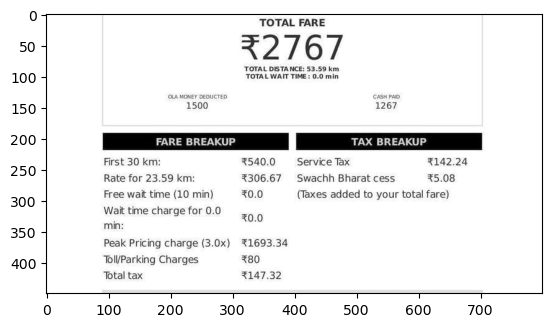

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


TOTAL FARE

22767

‘TOTAL DISTANCE: 53.59 km
TOTAL WAIT TIME: 0.0 min

‘R67

FARE BREAKUP TAX BREAKUP
First 30 km: 540.0 Service Tax 142.24
Rate for 23.59 km: 306.67 Swachh Bharat cess 35.08
Free wait time (10 min) 0.0 (Taxes added to your total fare)
Wat time chargefor 0.0 24 4
min:
Peak Pricing charge (3.0x) 1693.34
Toll/Parking Charges 80

Total tax 147.32



 71%|███████   | 17/24 [00:52<00:21,  3.12s/it]

outStuff:  Travel Category - Cab Bill/Receipt
Confidence Yo:  tensor(0.9853)








../sampleData/cabBills_51.png


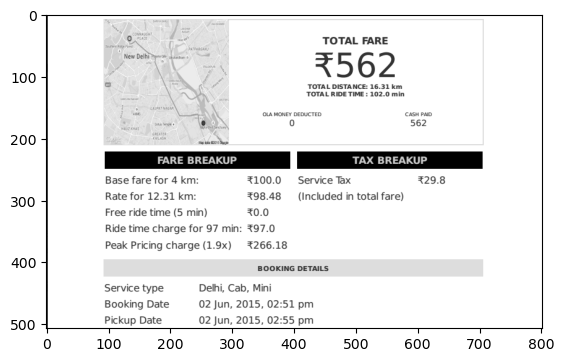

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


e TOTAL FARE

Sf %562

‘TOTAL DISTANCE: 16.31 km
‘TOTAL RIDE TIME : 102.0 min

° 0 562

FARE BREAKUP TAX BREAKUP

Base fare for 4 km: 3100.0 Service Tax 329.8
Rate for 12.31 km: 98.48 (Included in total fare)

Free ride time (5 min) 20.0

Ride time charge for 97 min: 97.0

Peak Pricing charge (1.9x) 2266.18

BOOKING DETAILS

Service type Delhi, Cab, Mini
Booking Date 02 Jun, 2015, 02:51 pm
Pickup Date 02 Jun, 2015, 02:55 pm



 75%|███████▌  | 18/24 [00:54<00:17,  2.97s/it]

outStuff:  Travel Category - Cab Bill/Receipt
Confidence Yo:  tensor(0.9883)








../sampleData/flightTickets_11.png


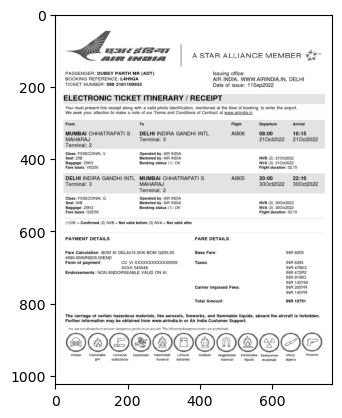

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


guint A STAR ALLIANCE MEMBER we =

SEMEE TAPER ee
PASSENGER: DUBEY PARTH MR (ADT) Issuing office:
BOOKING REFERENCE: LAH9QA, AIR INDIA, WWW.AIRINDIA.IN, DELHI
TICKET NUMBER: 098 2161109933 Date of issue: 11Sep2022

ELECTRONIC TICKET ITINERARY / RECEIPT

‘You must present this receipt along with a valid photo identification, mentioned at the time of booking, to enter the airport.
We seek your attention to make a note of our Terms and Conditions of Contract at www.alrindia.in

From To Fright Departure Arrival

MUMBAI CHHATRAPATIS DELHI INDIRA GANDHI INTL. Als06 08:00 10:15

MAHARAJ Terminal: 3 21012022 210ct2022

Terminal: 2

Class: FXSECOININ, V Operated by: AIR INDIA

‘Seat: 258 Marketed by: AIR INDIA NVB (2): 21002022

Baggage: 25KG Booking status (1): 0K NVA (3): 210012022

Fare basis: VSDS0 Flight duration: 02:15

DELHI INDIRA GANDHI INTL MUMBAI CHHATRAPATI S Alg05 20:00 22:40

Terminal: 3 MAHARAJ 300ct2022 — 300ct2022
Terminal: 2

Class: FXSECOININ, @ Operated by: AIR INDIA

‘Seat:

 79%|███████▉  | 19/24 [00:59<00:17,  3.43s/it]

outStuff:  Travel Category - Flight Ticket
Confidence Yo:  tensor(0.7944)








../sampleData/gadgetsBills_10.png


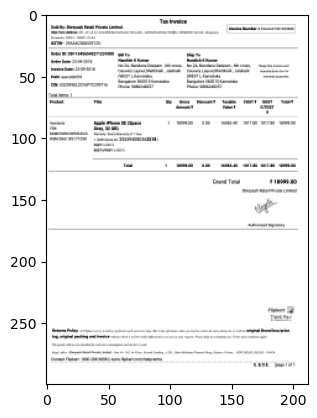

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


 83%|████████▎ | 20/24 [01:00<00:11,  2.90s/it]

outStuff:  Travel Category - Cab Bill/Receipt
Confidence Yo:  tensor(1.)








../sampleData/restaurantBills_18.png


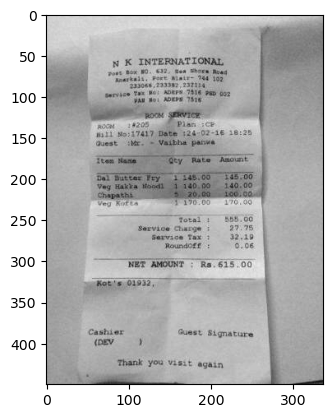

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


wy K INTERNATIONAL

sleet 0.632 So ses Rog
"artets voce sage me
Shiece’tane ai

5500
27.75

22.19
Orr

Cashier Guest Signature
weve)

‘Thank you visit again




 88%|████████▊ | 21/24 [01:03<00:08,  2.74s/it]

outStuff:  Food Category - Restaurant Bill/Receipt
Confidence Yo:  tensor(0.8531)








../sampleData/restaurantBills_19.png


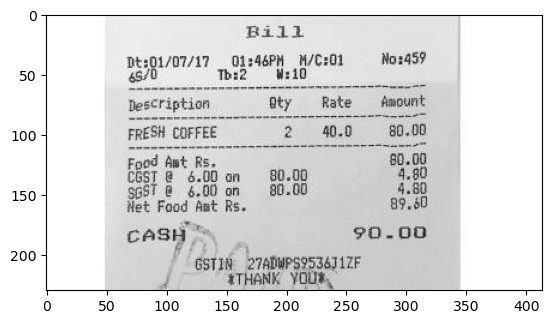

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Food fut Rs,
CEST @ 4.00 on
5637 @ 6.00 on
Het Food Aut Rs.

*esnin_ eras
j ATHANK YI




 92%|█████████▏| 22/24 [01:05<00:04,  2.45s/it]

outStuff:  Food Category - Restaurant Bill/Receipt
Confidence Yo:  tensor(0.9592)








../sampleData/gadgetsBills_15.png


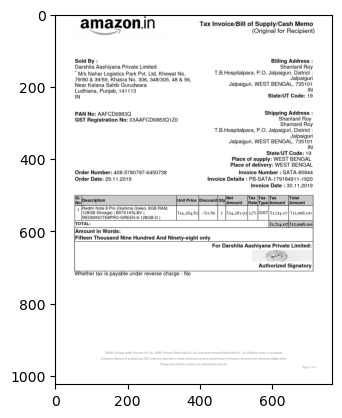

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


amazon.in

Sold By:

Darshita Aashiyana Private Limited

* M/s Nahar Logistics Park Pvt. Ltd, Khewat No.
79/80 & 39/59, Khasra No. 306, 348/305, 48 & 56,
Near Katana Sahib Gurudwara

Ludhiana, Punjab, 141113

IN

PAN No: AAFCD6883Q
GST Registration No: 03AAFCD6883Q1Z0

Order Number: 408-5780797-6450738
Order Date: 29.11.2019

Tax Invoice/Bill of Supply/Cash Memo
(Original for Recipient)

Billing Address :
Shantanil Roy

T.B Hospitalpara, P.O. Jalpaiguri, District
Jalpaiguri

Jalpaiguri, WEST BENGAL, 735101
IN
State/UT Code: 19

Shipping Address :
Shantanil Roy
Shantanil Roy
T.B Hospitalpara, P.O. Jalpaiguri, District
Jalpaiguri
Jalpaiguri, WEST BENGAL, 735101
IN
State/UT Code: 19
Place of supply: WEST BENGAL
Place of delivery: WEST BENGAL
Invoice Number : SATA-85944
Invoice Details : PB-SATA-179184911-1920
Invoice Date : 30.11.2019

Pescription ini Price [oiscounfanyNe iy eee unt [Ec

1 [sgh Note 8 Pro (Gamma Green, 6GB RAW,
teeca Storage) SUrxIKSLEV fag.axe8a] too | 1 frxgasso5}12% fo

 96%|█████████▌| 23/24 [01:08<00:02,  2.64s/it]

outStuff:  Electronics Category - Electronic Gadgets Bill/Receipt
Confidence Yo:  tensor(0.9817)








../sampleData/flightTickets_9.png


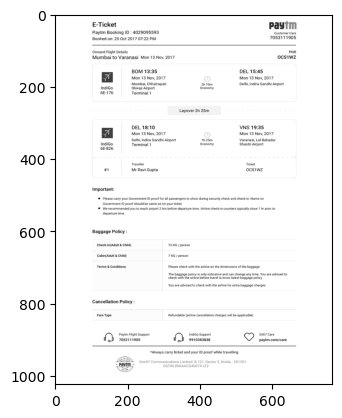

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


E-Ticket Paytm
Paytm Booking ID : 4029095593 pete
Booked on: 25 Oct 2017 07:22 PM 7083111905
nar Fight Details uk
Mumbai to Varanasi Mon 13 Nov, 2017 ocs1Wwz
BOM 13:35, DEL 15:45
fd Mon 13 Nov, 2017 Mon 13 Nov, 2017
Mumbal chatapat avin Det ra Gandhi pot
Indio Svat Apo as,
66176 Terminal
Layover 2h 25m
DEL 18:10 VNS 19:35,
Mon 13 Nov, 2017 Mon 13 Nov, 2017
Deh nda Gandhi port zim Voranasi al Gohadr
Indio Terminal t new Shunt Apr
cere
Tree Tet
a MrRavi Gupta ocstwz
Inmportant:

‘© Please ctr your Government 10 proof fora passengers to show dung sect check and checkin. Namen
‘Goverament ID poo! shouldbe same a on your ket
'¢ Werecommended you to reach arport 2s before departure time, rine checkin counters typeally cose Tf ror

parte time
Baggage Policy

‘Checktndult & Cite) 156 sperson

Ccabingaaut& cid) 7G / person

‘Teams & Conditions lease chick with the aie on the dimensions of the Bagge

‘Tee Baggaoe pole it oly ndieatie and can change any te, You ae advied to
checkin the sri before

100%|██████████| 24/24 [01:11<00:00,  2.98s/it]

outStuff:  Travel Category - Flight Ticket
Confidence Yo:  tensor(0.4881)










In [42]:
for i in tqdm.tqdm(imgFiles, colour = "red"):
    imgName = i
    print(imgName)
    img = cv2.imread(imgName, 0)
    plt.imshow(img, cmap = "gray")
    plt.show()
    txtOut = pytesseract.image_to_string(img)
    print(txtOut)
    encodedData = tokenizer(txtOut, padding="max_length", truncation=True, max_length=512)
    input_ids = torch.tensor([encodedData["input_ids"]], dtype=torch.uint8).to(device).long()
    attention_mask = torch.tensor([encodedData["attention_mask"]], dtype=torch.uint8).to(device)
    with torch.no_grad():
      outputs = loraModel(input_ids=input_ids, attention_mask=attention_mask)
      logits = outputs.logits
      predOut = torch.argmax(logits, dim=1)
    confVals = torch.nn.functional.softmax(logits, dim=1)
    print("outStuff: ", labelMap[predOut.item()])
    print("Confidence Yo: ", confVals[0, predOut.item()])
    print("\n\n\n\n\n\n\n")

  0%|          | 0/24 [00:00<?, ?it/s]

../sampleData/trainTickets_22.png


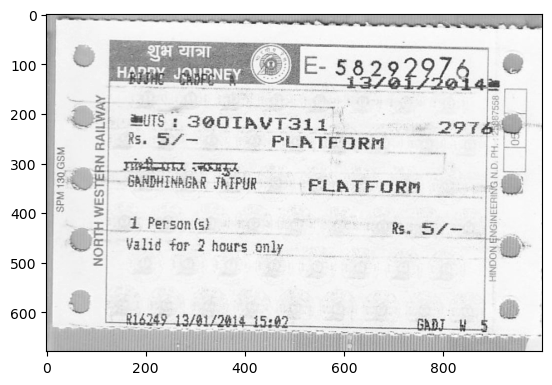

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Ja at

HAD JOCSNE hs

ayts 3 | S@0TAVT311 | mw 2o7ep

6. SY 0 PLATFORM ees
=
g _Tidiar sag 2
8 ~ GANDHINAGAR JAIPUR PLATFORM jo
= =

Valid for 2 hours only _

g
=

_4i Person(s} &. S/—. ae




  4%|▍         | 1/24 [00:02<00:58,  2.54s/it]

outStuff:  Travel Category - Train Ticket
Confidence Yo:  tensor(0.7326)








../sampleData/restaurantBills_17.png


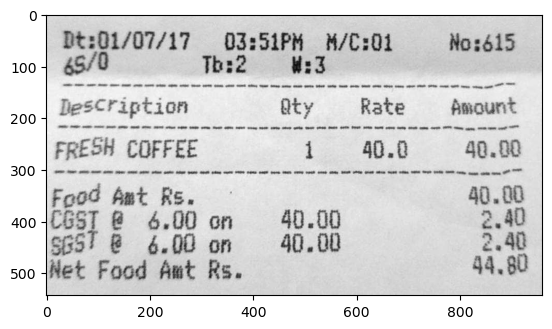

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Dt:01/07/17 03:51PM M/C:01 No:615
65/0 Th:2 :

Ws
Description Qty Rate  fmount
FRESH COFFEE i 40.0 40.00
Food Aut Rs. 40.00
C65T @ 6.00 on 40.00 2.40
s651 @ 4.00 on 40.00 2.40

Net Food Amt Rs. 44,80



  8%|▊         | 2/24 [00:04<00:52,  2.38s/it]

outStuff:  Food Category - Restaurant Bill/Receipt
Confidence Yo:  tensor(0.9986)








../sampleData/trainTickets_20.png


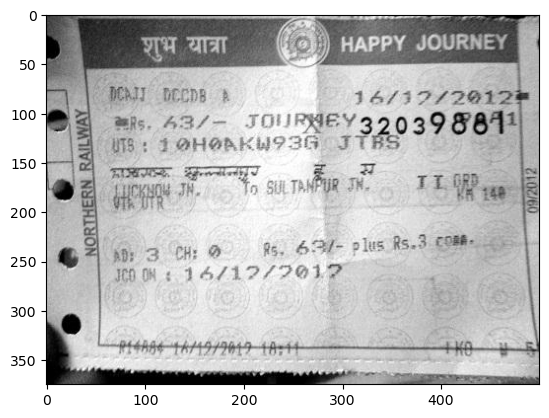

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
 12%|█▎        | 3/24 [00:05<00:35,  1.69s/it]

16/37/2012

Ti Fie rid TL Op.
jg “4 on Tae


outStuff: Miscellaneous Category - Miscellaneous Bills








../sampleData/trainTickets_21.png


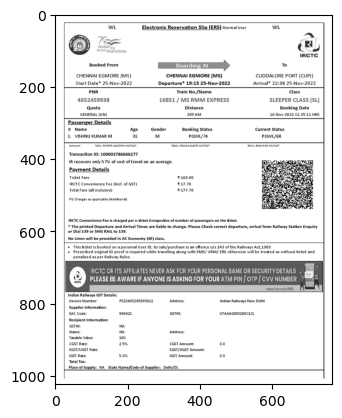

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


wi Reservation Slip (ERS)-Normal User we
5 -— re]
Azaditg
Athos Go”)
IRCTC
Booked From Board To
‘CHENNAI EGMORE (MS) CHENNAI EGMORE (Ms) CUDDALORE PORT (CUPS)
Start Date* 25-Nov-2022 Departure* 19:15 25-Nov-2022 Arrival* 22:38 25-Nov-2022
PNR Train No/Name Class
4652459938 16851 / MS RMM EXPRESS SLEEPER CLASS (SL)
Quota Distance Booking Date
GENERAL (GN) 205 KM. 16-Nov-2022 11:25:11 HRS
Passenger Details
# Name Age Gender Booking status Current status
1. VISHNU KUMAR M 3h M Pawl/74 Pawves

‘Transaction ID: 100003786666277
IR recovers only 57% of cost of travel on an average.

Payment Detail
Ticket Fare 160.00
IRCTC Convenience Fee (inc. of GST) 17.70

Total Fare (all inclusive) "177.70

Charges 2s applicable (Addiiona)

IRCTC Convenience Fee is charged per e-ticket irrespective of number of passengers on the ticket.
"The printed Departure and Arrival Times are liable to change. Please Check correct departure, arrival from Railway Station Enquiry
(or Dial 139 or SMS RAIL to 139.

No Lin

 17%|█▋        | 4/24 [00:08<00:45,  2.26s/it]

outStuff:  Travel Category - Train Ticket
Confidence Yo:  tensor(0.9993)








../sampleData/busTickets_4.png


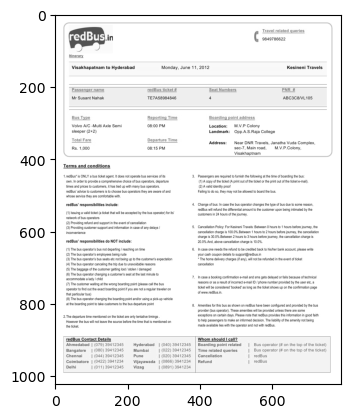

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


redBusky
2

inerary

isakhapatnam to Hyderabad

Monday, June 11, 2012

Travel related queries
4 9849786622

Kesineni Travels

Passengername redBus ticket #

Seat Numbers PNR

Mr Susant Nahak TE7ASBOB4846

4 ABC3CBIVL105

Bus Type Reporting Time
Volvo AIC -Multi Axle Semi 08:00 PM
sleeper (2+2)

Total Fare Departure Time
Rs. 1,000 08:15 PM

‘Terms and conditions

{.rous"is ONLY a bus ket agent It does not pera bus senes ots
‘un. n créer to provide a comprehensive chico of bus operators, depare
{irae and past customers, has dup with many bus operas
‘edBus' ice to customers stn chose bus cpeaos they are anare of ard
hose serice hey are confab wit,

‘redBus' responsibilities include:

(1) suing vali cat (atcha tat ibe accaple bythe bus operator rite
etn of bus operators

(2) roving refund and supa in the evento canolaton

{@) Proving customer support and informatn in case of any clays

‘edBus' responsibilities do NOT include:

(1) The bus operat bs ot departing tectngon ine
(2) The bus ope

 21%|██        | 5/24 [00:12<00:55,  2.90s/it]

outStuff:  Travel Category - Bus Ticket
Confidence Yo:  tensor(0.9790)








../sampleData/fuelBills_141.png


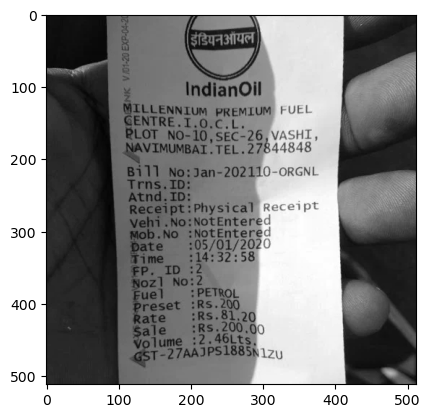

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
 25%|██▌       | 6/24 [00:13<00:39,  2.21s/it]

VASHI,

10-ORGNL

eceipt


outStuff: Miscellaneous Category - Miscellaneous Bills








../sampleData/stayReceipts_12.png


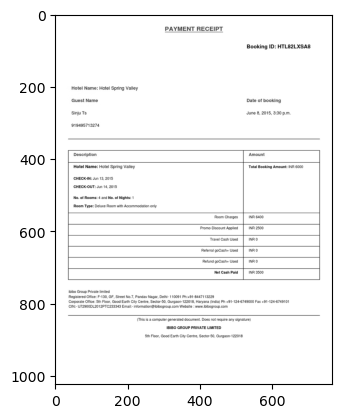

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Hotel Name: Hotel Spring Valley

PAYMENT RECEIPT

Booking ID: HTL82LXSA8

Guest Name Date of booking
Sinju Ts June 8, 2015, 3:30 p.m.
919498713274

Description ‘Amount

Hotel Name: Hotel Spring Valley

CHECKAN: Jun 13, 2015,
‘CHECK-OUT: Jun 14,2015,

No.of Rooms: 4 snd No.of Nights:

Room Type: Deluxe Room with Accommodation only

‘Total Booking Amount: INR 6000

Room Charges | INA 6400

Promo-DacountAppied | INR 2300
Travel Gash Used | RO
Reteralgocash« Uses | NRO
Retund goCashs Used | INRO

Netash Paid | INA 9500

Ibibo Group Privat ited

Registered Otce:F-180, GF, Sueet No.7, Pandav Nagar, Deh- 110081 Ph:+81-8447118228
Corporate Otice: Sth Floor, Good Earth Gly Centre, Sector-50, Gurgaon-122018, Haryana (Inia) Ph +91-124:6749000 Fax +91-126-6749101
{GIN U72900012012°TC28384S Emal- information bibogroup com Website : www. biboproup.com

(This isa computer generated document, Does not requie any signature)

IBIBO GROUP PRIVATE LIMITED

‘5th Floor, Good Earth Cy Centre, Sectr-50, Gurga

 29%|██▉       | 7/24 [00:15<00:35,  2.08s/it]

outStuff:  Room Stay Category - Stay Bill/Receipt
Confidence Yo:  tensor(0.7454)








../sampleData/stayReceipts_13.png


libpng warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


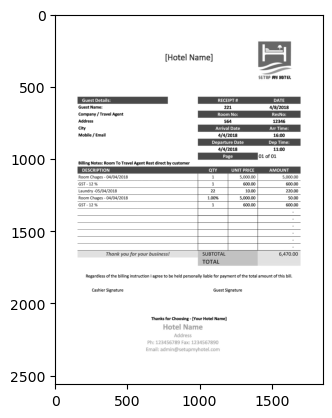

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


[Hotel Name]

SETUP MY HOTEL

Guest Name: siBienns
Address ee

cy
Mobile / Email 4/4/2018 16:00

Departure Date Dep Time:

4/4/2018 11:00

TT 01 of 01

Billing Notes: Room To Travel Agent Rest direct by customer

DESCRIPTION UNIT PRICE AMOUNT
Room Chages - 04/04/2018 5,000.00 5,000.00
GST-12% 600.00 600.00
Laundry -05/04/2018 10.00 220.00
Room Chages - 04/04/2018 5,000.00 50.00
GST-12% 600.00 600.00

Thank you for your business! SUBTOTAL 6,470.00

TOTAL
Regardless of the billing instruction | agree to be held personally liable for payment of the total amount of this bill.

Cashier Signature Guest Signature

Thanks for Choosing - [Your Hotel Name]

Hotel Name
Address
Ph: 123456789 (: 1234567890
Email: admin@setupmyhotel.com




 33%|███▎      | 8/24 [00:18<00:40,  2.50s/it]

outStuff:  Room Stay Category - Stay Bill/Receipt
Confidence Yo:  tensor(0.7795)








../sampleData/fuelBills_140.png


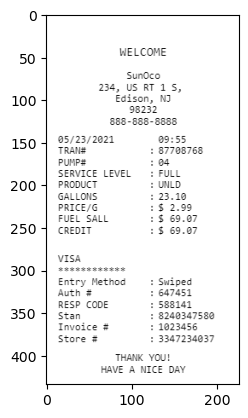

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


WELCOME

Sundco
234, US RT 1S,
Edison, NI
98232

888-888-8888
05/23/2021 29:55
TRANS +: 87708768
PUNE 24
SERVICE LEVEL: FULL
PRODUCT UNLD
GALLONS 23.18
PRICE/G $ 2.99
FUEL SALL $ 69.07
CREDIT $ 69.07
VISA
Entry Method: Suiped
Auth # 647451
RESP CODE 588141
Stan 5240347580
Invoice 11023456
Store # 3347234037

THANK YOU!

HAVE A NICE DAY



 38%|███▊      | 9/24 [00:20<00:33,  2.23s/it]

outStuff:  Travel Category - Bus Ticket
Confidence Yo:  tensor(0.2282)








../sampleData/busTickets_2.png


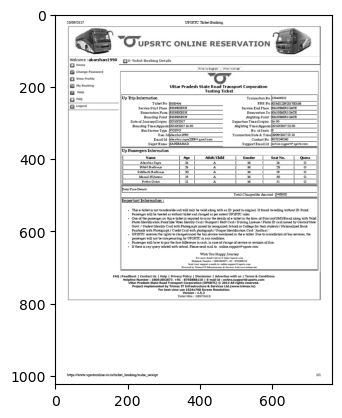

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


09017

LUPSRIC Ticket Booking,

1 crange Password
1 view Prone

My Booking
aM

ane

Topout

~~ .
© ‘Gorsrtc ONLINE RESERVATION y

‘Welcome :akarshani990_ (3 £-Ticket Booking Details

Uttar Pradesh State Road Transport Corporation

Testing Ticket
[Up Tip Information Franaction Vo PA?
Tiel o ss5086 PNR No SRGEOSOTROESS
Servee Start Place: REEDS, ‘Service Ena Place: KASERORIGATE
Reservation Fon SHEESH Reservation To, KASIOEREGATE.
Boarding Point SEEKS _Abgting Post: FASEDGRI GATE
Date of Journey Origin) POOR Departure Tune(Origay 630)
‘Bouding Tim e( Approx BOO017 1630 Alighting Tne Apps NOIT=SIO
‘BusServee Type WOEVO Yo ofSeats:B.
‘Use Linn ‘Teansaction Date & Time SOAR
Ewald: Waste peSiOve pea Contact No: PeESeI0_
| Depot Name FABIBARAD. Soypost Email ld: belnereppen@upreco=
Up Passengers Information
L ‘Name i ‘Gender [SeatNe. [Quota
i “Riawhns Sap L

foe
mal
ca

+ Thise-setetis not tmnsfenble and wil nly be valid along with an prot i ougial own raveling wthoet ID roo,
‘Passenger willbe

 42%|████▏     | 10/24 [00:23<00:35,  2.53s/it]

outStuff:  Travel Category - Bus Ticket
Confidence Yo:  tensor(0.8192)








../sampleData/gadgetsBills_9.png


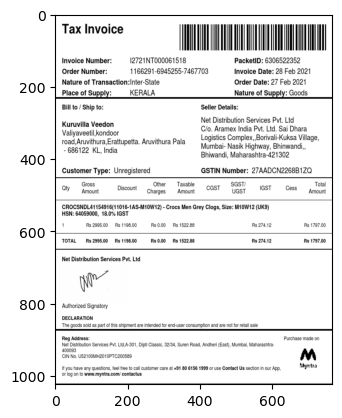

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


mess

Invoice Number: 12721NT000061518 PacketID: 6306522352
Order Number: 1166291-6945255-7467703 Invoice Date: 28 Feb 2021
Nature of Transaction:Inter-State Order Date: 27 Feb 2021
Place of Supply: KERALA Nature of Supply: Goods
Bill to / Ship to: Seller Details:

Net Distribution Services Pvt. Ltd

C/o. Aramex India Pvt. Ltd. Sai Dhara
Logistics Complex,,Borivali-Kuksa Village,
Mumbai- Nasik Highway, Bhinwandi,,
Bhiwandi, Maharashtra-421302

Kuruvilla Veedon

Valiyaveetil,kondoor
road,Aruvithura,Erattupetta. Aruvithura Pala
- 686122 KL, India

Customer Type: Unregistered GSTIN Number: 27AADCN2268B1ZQ.
Gross Other Taxable sGsT/ Total

Qty Amount Discount Charges Amount CST ygst «GST CSS Amount

CROCSNDL41154916(11016-1AS-M10W/12) - Crocs Men Grey Clogs, Size: M10W12 (UK)

HSN: 64059000, 18.0% IGST

1 Rs 2995.00 Rs 1198.00 Rs0.00 Rs 1522.68 Rs 274.12 Rs 1797.00

TOTAL Rs 2995.00 Rs 1198.00 Rs 0.00 Rs 1522.88 Rs 274.12 Rs 1797.00

Net Distribution Services Pvt. Ltd

Authorized Signatory

 46%|████▌     | 11/24 [00:26<00:34,  2.68s/it]

outStuff:  Electronics Category - Electronic Gadgets Bill/Receipt
Confidence Yo:  tensor(0.9920)








../sampleData/fuelBills_142.png


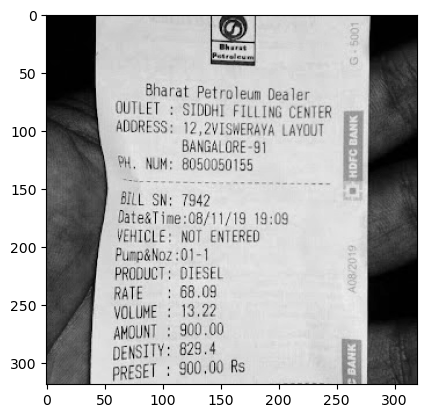

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


ie

Bharat Petroleum Dea
TDOHI FILLING CE

BILL SN: 7942
DateaT ine=08/11/19 19:09

VEHICLE: NOT ENTERED
PumpaNoz :01

PRODUC’

RATE

VOLUME : 13. 2
AMOUNT. = 800,00

829.4
900,00 Rs




 50%|█████     | 12/24 [00:28<00:29,  2.49s/it]

outStuff:  Fuel Category - Fuel Bill/Receipt
Confidence Yo:  tensor(0.9983)








../sampleData/stayReceipts_11.png


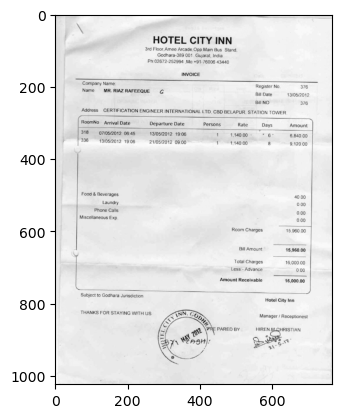

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


HOTEL CITY INN

31d Floor Ame Arcade,Opp Main Bus Stand,
Godhara-389 001. Gujarat, India
Ph:02672-252994 Mo'+91-76006 43440

INVOICE

Company Name Register No. 376
Name  MR.RIAZRAFEEQUE BillDate 19/08/2012

Bill NO 376
Address CERTIFICATION ENGINEER INTERNATIONAL LTD. CBD BELAPUR, STATION TOWER

RoomNo Arrival Date Departure Date Persons Rate Days Amount
318 0770572012 06:45 13/05/2012 19:06 1 114000" * 6° 6840.00
936 "19/05/2012 1906 21/05/2012 09.00 1 4.14000 8 9,120.00
Food & Beverages 40.00
Laundry 000
Phone Calls 0.00
Miscellaneous Exp 0.00
Room Charges 1,960.00
Bil Amount 15,960.00
Total Charges 16,000.00
Less - Advance 0.00
Amount Receivable 16,000.00

‘Subject to Godhara Jurisdiction Hotel City Inn

THANKS FOR STAYING WITH US Manager / Receptionest

PARED BY HIREN.M.QHRISTIAN

en
w?




 54%|█████▍    | 13/24 [00:31<00:26,  2.44s/it]

outStuff:  Room Stay Category - Stay Bill/Receipt
Confidence Yo:  tensor(0.9337)








../sampleData/busTickets_3.png


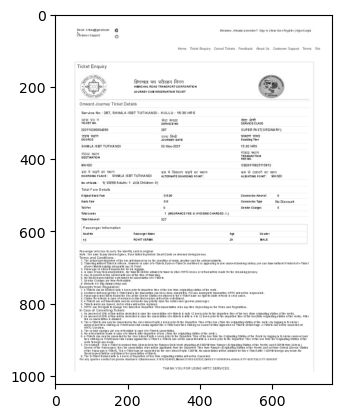

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


enema @ eto Ama amenbr Syn te rages ates
Siemon

Home Tiket Enquiry Cancel Ticats Feedback Abot Us Customer Support Tems Shi

Ticket Enquiry

> ‘fare ver atiaea Pere

oe
‘Onward Journey Ticket Details

‘Service No = 287, SHIMLA ISBT TUTIKANDI- KULLU : 15:30 HRS.

ero" So Rive
ocwesnouso a SuPeR rsTIORONARY)
sem ara i ——
mar Sates ae
SHIMLA IST TUTKANOL onevan 1500 HRS
re ie
saa wet a eo S04 ee woh 7 wr a8 owe an
Tinouo vce SHEA BETTUTHANOL — MetaneTonnion Mouse Momo rowr uavor
vero REARS: ae Cee: 0}
Teal Fare Data
ry Site inant
= cominnton —_ WeOsceut
oumcnm 6
; Somer RSSECoRTSTS
Ea
assengeInfrmaton
oo asp '* aia
‘s rownvenun 5 we

gy no ha cary be wnt earain or
SSW tna ane Dpayobeottghefyou ike poate Smarcant orm

sFubethou Sight cain Sie wie

"Efotitpns bor anprure one othe bu gam arghang Ha

cpa mrcmmame sai orae pee) oy momen Bux
GGpeamson Tineh oransage ered caster .

Pore) ame

cna te ast

yestaaby ae ett a eae ae

ise p 0 Nocatee

Fate tonin  aiateap mes

caSneses aura 96160505 

 58%|█████▊    | 14/24 [00:34<00:27,  2.76s/it]

outStuff:  Travel Category - Bus Ticket
Confidence Yo:  tensor(0.6022)








../sampleData/cabBills_49.png


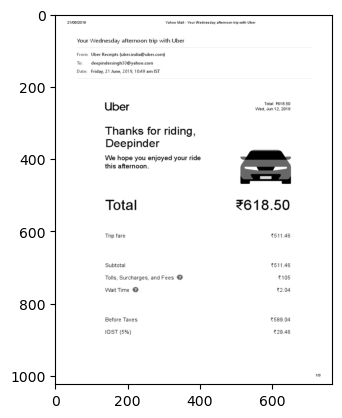

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


2vo8r2010 ‘Yahoo Mail- Your Wednesday afternoon tip with Uber

Your Wednesday afternoon trip with Uber

From: Uber Receipts (ub

\dia@ uber.com)

To: — deepindersingh30@yahoo.com

Friday, 21 June, 2019, 10:49 am IST

ame
Uber Wed jan 12,2018

Thanks for riding,
Deepinder

We hope you enjoyed your ride
this afternoon.

Total 2618.50

Trip fare 3511.46
‘Subtotal 511.46
Tolls, Surcharges, andFees @ 105
Wait Time @ 2.04
Before Taxes 589.04

IGST (5%) §29.48

12



 62%|██████▎   | 15/24 [00:36<00:22,  2.50s/it]

outStuff:  Travel Category - Cab Bill/Receipt
Confidence Yo:  tensor(0.9372)








../sampleData/flightTickets_10.png


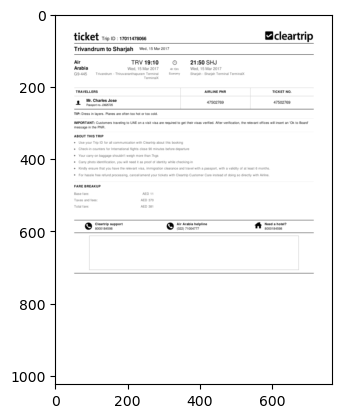

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


ticket rico: rzo1ra7e066 Qcleartrip

Trivandrum to Sharjah Wed, 15 Mar2017

Air TRV 19:10 fo} 21:50 SHJ

Arabia Wed, 15Mar 2017 Wed, 15 Mar 201

‘TRAVELLERS AIRLINE PNR TICKET NO.
Mr. Charles Jose
2 ries Jot 47502769 47502769

TIP: Dress in layers. Panes ae ten 100 hot 100 cold

IMPORTANT: Customers waving to UAE ona vit isa ae requived to get tha visas verted Alter veiicaio, the elovantotices wi lnsen an‘ to Boar
message n the PNA,

ABOUT THIS TRIP.

FARE BREAKUP
Cleartrip support ‘Ar Arabia hep Need a hotel?

eooot84so8 (c22) 71008777




 67%|██████▋   | 16/24 [00:38<00:18,  2.28s/it]

outStuff:  Room Stay Category - Stay Bill/Receipt
Confidence Yo:  tensor(0.3315)








../sampleData/cabBills_50.png


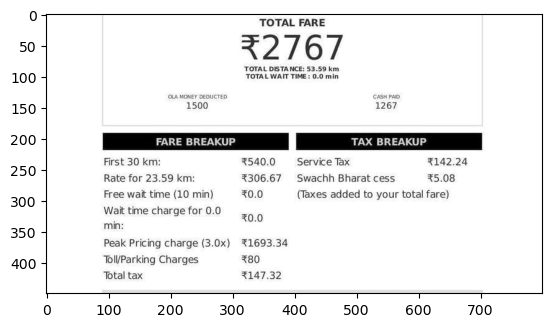

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


TOTAL FARE

22767

‘TOTAL DISTANCE: 53.59 km
TOTAL WAIT TIME: 0.0 min

‘R67

FARE BREAKUP TAX BREAKUP
First 30 km: 540.0 Service Tax 142.24
Rate for 23.59 km: 306.67 Swachh Bharat cess 35.08
Free wait time (10 min) 0.0 (Taxes added to your total fare)
Wat time chargefor 0.0 24 4
min:
Peak Pricing charge (3.0x) 1693.34
Toll/Parking Charges 80

Total tax 147.32



 71%|███████   | 17/24 [00:40<00:14,  2.14s/it]

outStuff:  Travel Category - Cab Bill/Receipt
Confidence Yo:  tensor(0.9853)








../sampleData/cabBills_51.png


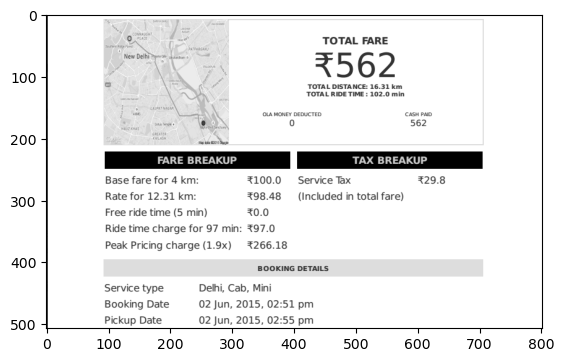

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


e TOTAL FARE

Sf %562

‘TOTAL DISTANCE: 16.31 km
‘TOTAL RIDE TIME : 102.0 min

° 0 562

FARE BREAKUP TAX BREAKUP

Base fare for 4 km: 3100.0 Service Tax 329.8
Rate for 12.31 km: 98.48 (Included in total fare)

Free ride time (5 min) 20.0

Ride time charge for 97 min: 97.0

Peak Pricing charge (1.9x) 2266.18

BOOKING DETAILS

Service type Delhi, Cab, Mini
Booking Date 02 Jun, 2015, 02:51 pm
Pickup Date 02 Jun, 2015, 02:55 pm



 75%|███████▌  | 18/24 [00:42<00:12,  2.13s/it]

outStuff:  Travel Category - Cab Bill/Receipt
Confidence Yo:  tensor(0.9883)








../sampleData/flightTickets_11.png


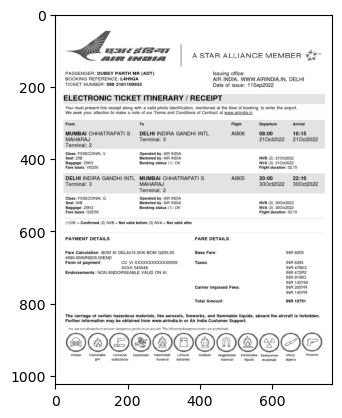

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


guint A STAR ALLIANCE MEMBER we =

SEMEE TAPER ee
PASSENGER: DUBEY PARTH MR (ADT) Issuing office:
BOOKING REFERENCE: LAH9QA, AIR INDIA, WWW.AIRINDIA.IN, DELHI
TICKET NUMBER: 098 2161109933 Date of issue: 11Sep2022

ELECTRONIC TICKET ITINERARY / RECEIPT

‘You must present this receipt along with a valid photo identification, mentioned at the time of booking, to enter the airport.
We seek your attention to make a note of our Terms and Conditions of Contract at www.alrindia.in

From To Fright Departure Arrival

MUMBAI CHHATRAPATIS DELHI INDIRA GANDHI INTL. Als06 08:00 10:15

MAHARAJ Terminal: 3 21012022 210ct2022

Terminal: 2

Class: FXSECOININ, V Operated by: AIR INDIA

‘Seat: 258 Marketed by: AIR INDIA NVB (2): 21002022

Baggage: 25KG Booking status (1): 0K NVA (3): 210012022

Fare basis: VSDS0 Flight duration: 02:15

DELHI INDIRA GANDHI INTL MUMBAI CHHATRAPATI S Alg05 20:00 22:40

Terminal: 3 MAHARAJ 300ct2022 — 300ct2022
Terminal: 2

Class: FXSECOININ, @ Operated by: AIR INDIA

‘Seat:

 79%|███████▉  | 19/24 [00:46<00:13,  2.64s/it]

outStuff:  Travel Category - Flight Ticket
Confidence Yo:  tensor(0.7944)








../sampleData/gadgetsBills_10.png


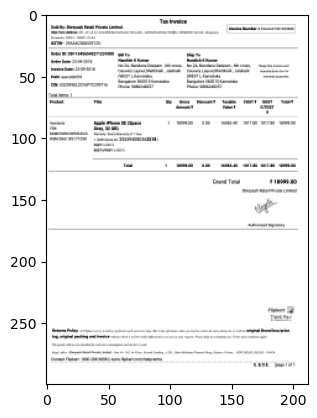

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
 83%|████████▎ | 20/24 [00:46<00:08,  2.04s/it]


outStuff: Miscellaneous Category - Miscellaneous Bills








../sampleData/restaurantBills_18.png


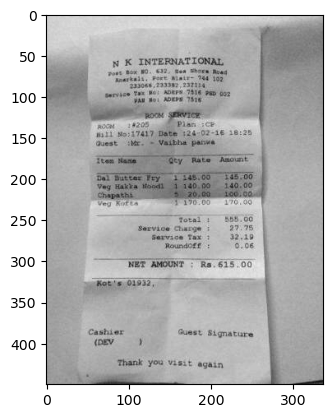

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


wy K INTERNATIONAL

sleet 0.632 So ses Rog
"artets voce sage me
Shiece’tane ai

5500
27.75

22.19
Orr

Cashier Guest Signature
weve)

‘Thank you visit again




 88%|████████▊ | 21/24 [00:48<00:05,  1.90s/it]

outStuff:  Food Category - Restaurant Bill/Receipt
Confidence Yo:  tensor(0.8531)








../sampleData/restaurantBills_19.png


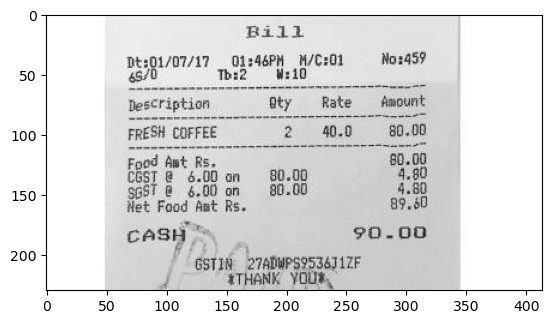

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Food fut Rs,
CEST @ 4.00 on
5637 @ 6.00 on
Het Food Aut Rs.

*esnin_ eras
j ATHANK YI




 92%|█████████▏| 22/24 [00:49<00:03,  1.76s/it]

outStuff:  Food Category - Restaurant Bill/Receipt
Confidence Yo:  tensor(0.9592)








../sampleData/gadgetsBills_15.png


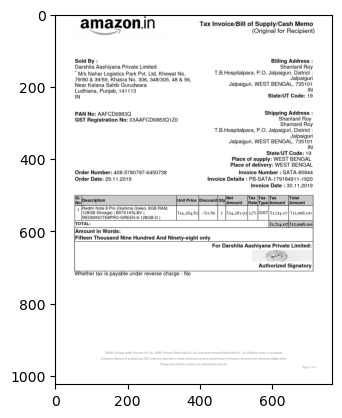

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


amazon.in

Sold By:

Darshita Aashiyana Private Limited

* M/s Nahar Logistics Park Pvt. Ltd, Khewat No.
79/80 & 39/59, Khasra No. 306, 348/305, 48 & 56,
Near Katana Sahib Gurudwara

Ludhiana, Punjab, 141113

IN

PAN No: AAFCD6883Q
GST Registration No: 03AAFCD6883Q1Z0

Order Number: 408-5780797-6450738
Order Date: 29.11.2019

Tax Invoice/Bill of Supply/Cash Memo
(Original for Recipient)

Billing Address :
Shantanil Roy

T.B Hospitalpara, P.O. Jalpaiguri, District
Jalpaiguri

Jalpaiguri, WEST BENGAL, 735101
IN
State/UT Code: 19

Shipping Address :
Shantanil Roy
Shantanil Roy
T.B Hospitalpara, P.O. Jalpaiguri, District
Jalpaiguri
Jalpaiguri, WEST BENGAL, 735101
IN
State/UT Code: 19
Place of supply: WEST BENGAL
Place of delivery: WEST BENGAL
Invoice Number : SATA-85944
Invoice Details : PB-SATA-179184911-1920
Invoice Date : 30.11.2019

Pescription ini Price [oiscounfanyNe iy eee unt [Ec

1 [sgh Note 8 Pro (Gamma Green, 6GB RAW,
teeca Storage) SUrxIKSLEV fag.axe8a] too | 1 frxgasso5}12% fo

 96%|█████████▌| 23/24 [00:53<00:02,  2.32s/it]

outStuff:  Electronics Category - Electronic Gadgets Bill/Receipt
Confidence Yo:  tensor(0.9817)








../sampleData/flightTickets_9.png


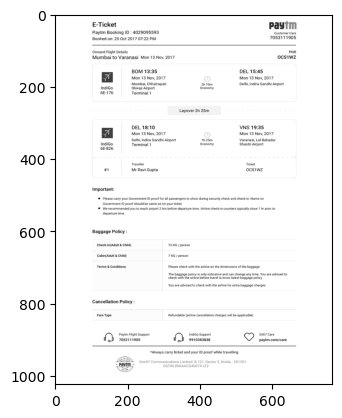

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


E-Ticket Paytm
Paytm Booking ID : 4029095593 pete
Booked on: 25 Oct 2017 07:22 PM 7083111905
nar Fight Details uk
Mumbai to Varanasi Mon 13 Nov, 2017 ocs1Wwz
BOM 13:35, DEL 15:45
fd Mon 13 Nov, 2017 Mon 13 Nov, 2017
Mumbal chatapat avin Det ra Gandhi pot
Indio Svat Apo as,
66176 Terminal
Layover 2h 25m
DEL 18:10 VNS 19:35,
Mon 13 Nov, 2017 Mon 13 Nov, 2017
Deh nda Gandhi port zim Voranasi al Gohadr
Indio Terminal t new Shunt Apr
cere
Tree Tet
a MrRavi Gupta ocstwz
Inmportant:

‘© Please ctr your Government 10 proof fora passengers to show dung sect check and checkin. Namen
‘Goverament ID poo! shouldbe same a on your ket
'¢ Werecommended you to reach arport 2s before departure time, rine checkin counters typeally cose Tf ror

parte time
Baggage Policy

‘Checktndult & Cite) 156 sperson

Ccabingaaut& cid) 7G / person

‘Teams & Conditions lease chick with the aie on the dimensions of the Bagge

‘Tee Baggaoe pole it oly ndieatie and can change any te, You ae advied to
checkin the sri before

100%|██████████| 24/24 [00:56<00:00,  2.35s/it]

outStuff:  Travel Category - Flight Ticket
Confidence Yo:  tensor(0.4881)










In [43]:
for i in tqdm.tqdm(imgFiles, colour = "blue"):
    imgName = i
    print(imgName)
    img = cv2.imread(imgName, 0)
    plt.imshow(img, cmap = "gray")
    plt.show()
    txtOut = pytesseract.image_to_string(img)
    print(txtOut)
    if len(txtOut)>50:
      encodedData = tokenizer(txtOut, padding="max_length", truncation=True, max_length=512)
      input_ids = torch.tensor([encodedData["input_ids"]], dtype=torch.uint8).to(device).long()
      attention_mask = torch.tensor([encodedData["attention_mask"]], dtype=torch.uint8).to(device)
      with torch.no_grad():
        outputs = loraModel(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        predOut = torch.argmax(logits, dim=1)
      confVals = torch.nn.functional.softmax(logits, dim=1)
      print("outStuff: ", labelMap[predOut.item()])
      print("Confidence Yo: ", confVals[0, predOut.item()])
    else:
      print("outStuff: Miscellaneous Category - Miscellaneous Bills")
    print("\n\n\n\n\n\n\n")